# Audio Embedding Clustering (openl3 fallback to MFCC)

This notebook demonstrates extracting audio embeddings using `openl3` (if available) or falling back to MFCC features with `librosa`. It clusters embeddings with UMAP + HDBSCAN/KMeans, provides sample playback cells, and evaluates clustering quality with silhouette and qualitative inspection.

# Install notes (uncomment in Colab)
# !pip install openl3 librosa umap-learn hdbscan scikit-learn soundfile

print('Uncomment install lines in Colab if required')

In [1]:
# Imports and sample audio generation/download
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
import hdbscan
from IPython.display import Audio, display

os.makedirs('audio_samples', exist_ok=True)
# Create a few synthetic audio clips (sine waves at different frequencies) as demo
sr = 22050
dur = 2.0
t = np.linspace(0, dur, int(sr*dur), endpoint=False)
freqs = [220, 440, 880, 1760]
audio_paths = []
for i, f in enumerate(freqs):
    y = 0.5*np.sin(2*np.pi*f*t) + 0.02*np.random.randn(len(t))
    p = f'audio_samples/sine_{f}hz.wav'
    sf.write(p, y, sr)
    audio_paths.append(p)

print('Created synthetic audio samples:', audio_paths)


Created synthetic audio samples: ['audio_samples/sine_220hz.wav', 'audio_samples/sine_440hz.wav', 'audio_samples/sine_880hz.wav', 'audio_samples/sine_1760hz.wav']


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


openl3 not available or failed; using MFCC fallback: No module named 'openl3'
MFCC embeddings shape: (4, 40)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Cluster Labels: [2 0 1 1]


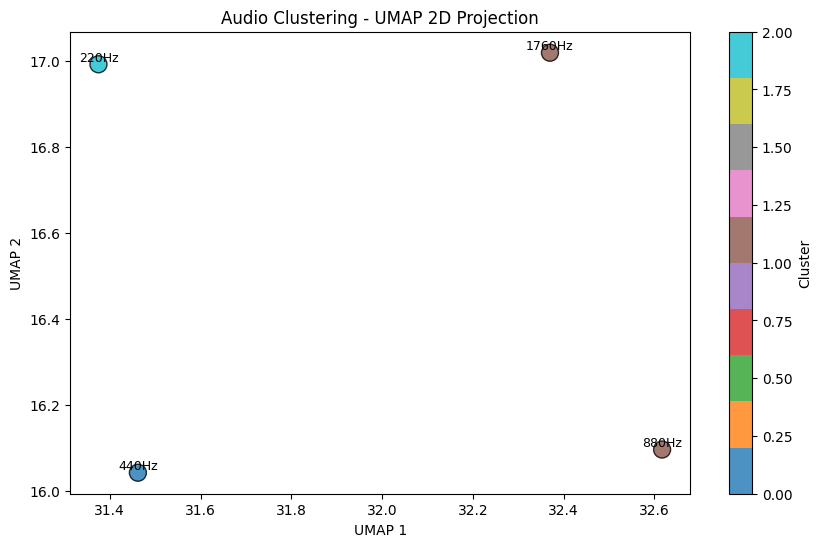

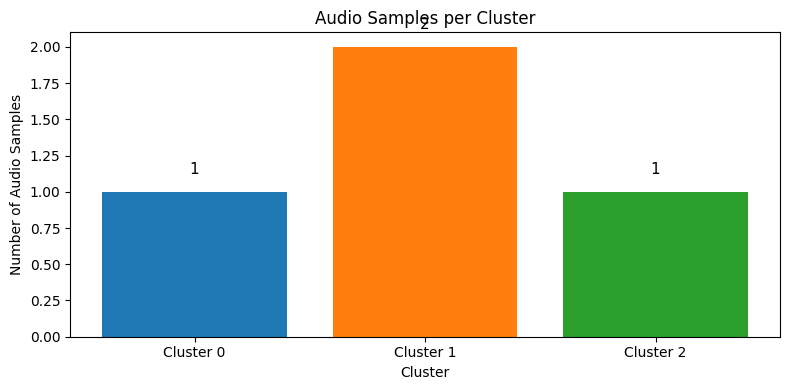

Silhouette Score: 0.0140


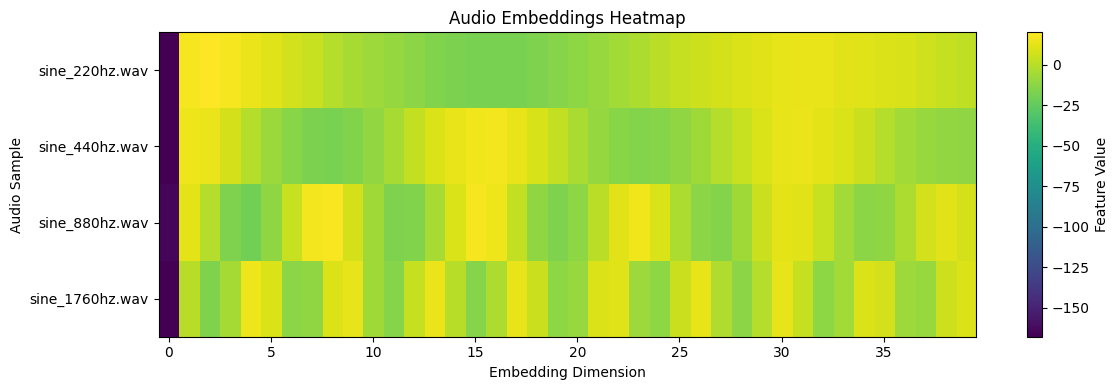

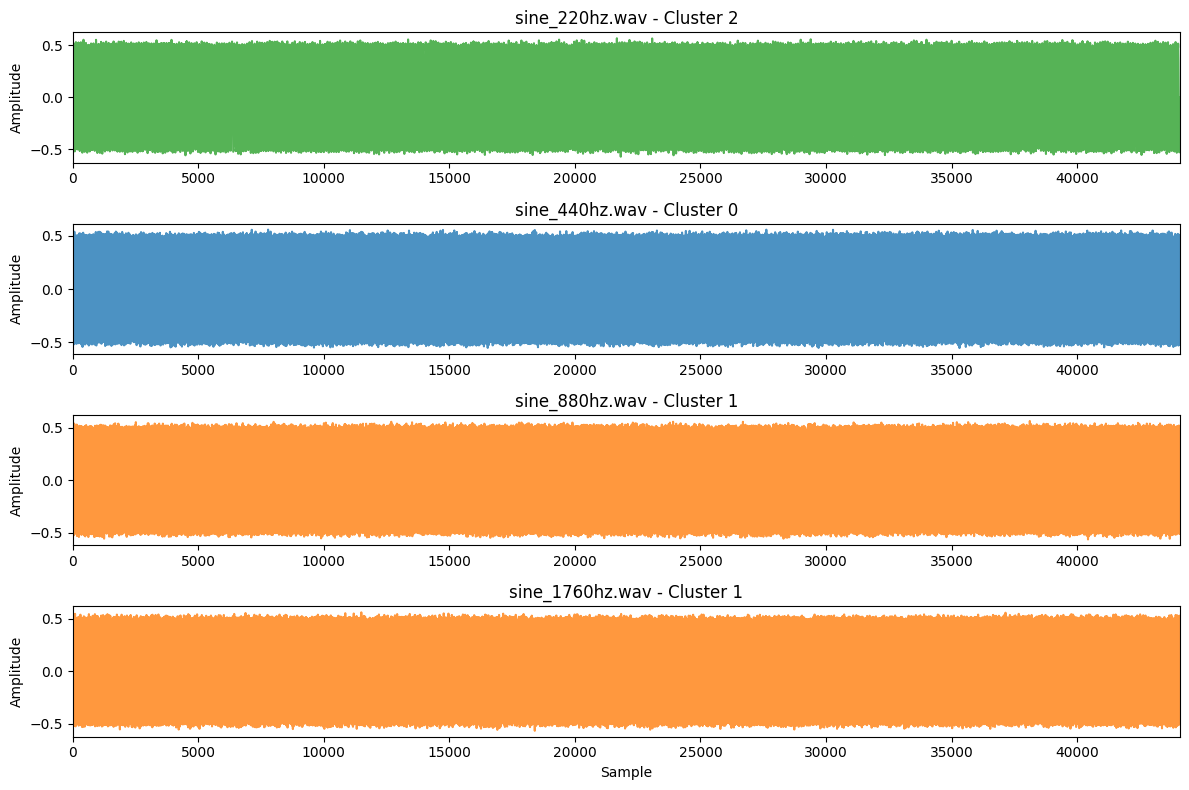


--- Spectrograms and Audio Playback per Cluster ---

Cluster 0 (samples: [np.int64(1)]):


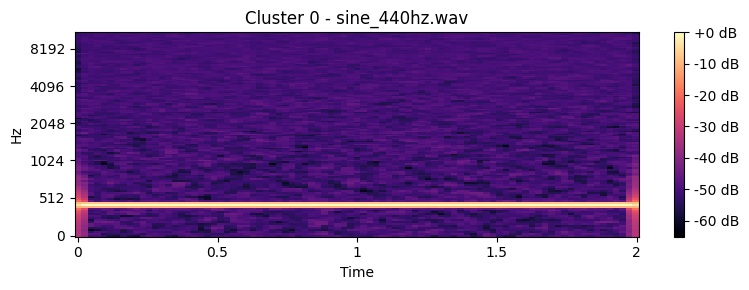


Cluster 1 (samples: [np.int64(2), np.int64(3)]):


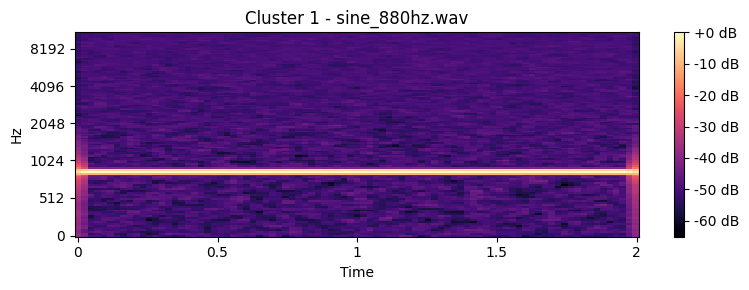

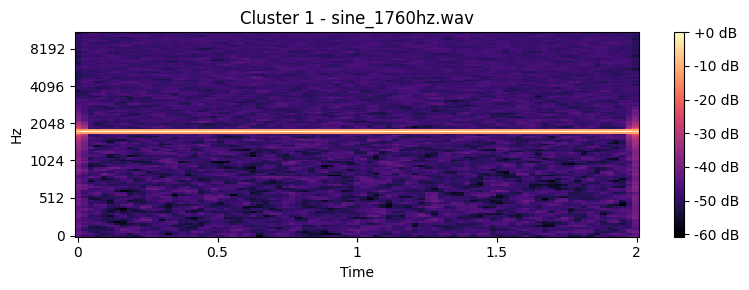


Cluster 2 (samples: [np.int64(0)]):


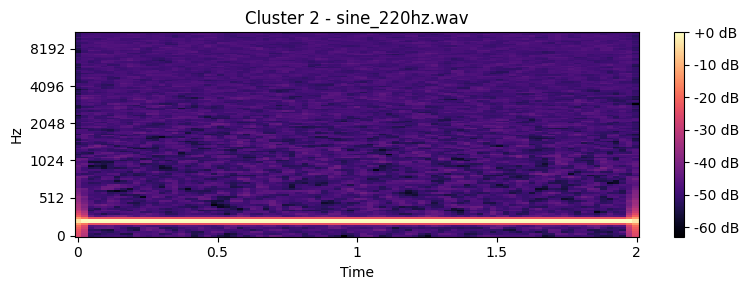


Saved audio_clusters_artifact.pkl


In [2]:
# Try openl3 embedding extraction; fallback to MFCCs
embs = []
try:
    import openl3
    for p in audio_paths:
        y, sr_loaded = librosa.load(p, sr=sr)
        emb, ts = openl3.get_audio_embedding(y, sr_loaded, content_type='music', embedding_size=512)
        # average pooling over time to get clip-level embedding
        embs.append(emb.mean(axis=0))
    embs = np.vstack(embs)
    print('openl3 embeddings shape:', embs.shape)
except Exception as e:
    print('openl3 not available or failed; using MFCC fallback:', e)
    for p in audio_paths:
        y, sr_loaded = librosa.load(p, sr=sr)
        mf = librosa.feature.mfcc(y=y, sr=sr_loaded, n_mfcc=40)
        embs.append(mf.mean(axis=1))
    embs = np.vstack(embs)
    print('MFCC embeddings shape:', embs.shape)

# Reduce dimension + cluster
reducer = umap.UMAP(n_components=2, random_state=42)
emb2 = reducer.fit_transform(embs)
labels = KMeans(n_clusters=min(3, len(embs)), random_state=42).fit_predict(embs)
print('Cluster Labels:', labels)

# --- Visualization 1: UMAP 2D scatter plot colored by cluster ---
plt.figure(figsize=(10, 6))
scatter = plt.scatter(emb2[:, 0], emb2[:, 1], c=labels, cmap='tab10', s=150, alpha=0.8, edgecolors='black')
for i, p in enumerate(audio_paths):
    freq = os.path.basename(p).replace('sine_', '').replace('hz.wav', '')
    plt.annotate(f'{freq}Hz', (emb2[i, 0], emb2[i, 1]), fontsize=9, ha='center', va='bottom')
plt.colorbar(scatter, label='Cluster')
plt.title('Audio Clustering - UMAP 2D Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# --- Visualization 2: Cluster distribution bar chart ---
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 4))
colors = [plt.cm.tab10(l % 10) for l in unique_labels]
bar_labels = [f'Cluster {l}' for l in unique_labels]
bars = plt.bar(bar_labels, counts, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of Audio Samples')
plt.title('Audio Samples per Cluster')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(count), ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

# --- Visualization 3: Silhouette score ---
from sklearn.metrics import silhouette_score
if len(np.unique(labels)) > 1:
    sil = silhouette_score(embs, labels)
    print(f'Silhouette Score: {sil:.4f}')

# --- Visualization 4: Embedding heatmap ---
plt.figure(figsize=(12, 4))
plt.imshow(embs, aspect='auto', cmap='viridis')
plt.colorbar(label='Feature Value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Audio Sample')
plt.yticks(range(len(audio_paths)), [os.path.basename(p) for p in audio_paths])
plt.title('Audio Embeddings Heatmap')
plt.tight_layout()
plt.show()

# --- Visualization 5: Waveforms comparison ---
fig, axes = plt.subplots(len(audio_paths), 1, figsize=(12, 2*len(audio_paths)))
for i, p in enumerate(audio_paths):
    y, sr_loaded = librosa.load(p, sr=sr)
    axes[i].plot(y, color=plt.cm.tab10(labels[i] % 10), alpha=0.8)
    axes[i].set_title(f'{os.path.basename(p)} - Cluster {labels[i]}')
    axes[i].set_ylabel('Amplitude')
    axes[i].set_xlim(0, len(y))
axes[-1].set_xlabel('Sample')
plt.tight_layout()
plt.show()

# --- Visualization 6: Spectrograms per cluster with playback ---
print('\n--- Spectrograms and Audio Playback per Cluster ---')
for cl in np.unique(labels):
    idxs = np.where(labels==cl)[0]
    print(f'\nCluster {cl} (samples: {list(idxs)}):')
    for i in idxs:
        y, sr_loaded = librosa.load(audio_paths[i], sr=sr)
        plt.figure(figsize=(8, 3))
        S = librosa.feature.melspectrogram(y=y, sr=sr_loaded)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr_loaded, x_axis='time', y_axis='mel')
        plt.title(f'Cluster {cl} - {os.path.basename(audio_paths[i])}')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
        display(Audio(audio_paths[i]))

# Save embeddings and labels
import joblib
joblib.dump({'audio_paths': audio_paths, 'embeddings': embs, 'labels': labels}, 'audio_clusters_artifact.pkl')
print('\nSaved audio_clusters_artifact.pkl')